# Compare tau decay distributions between Tauola and IceCube simulations

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("../")
from utils.hepmc_io import load_hepmc 
from collections import Counter
import numba
import pyhepmc

## Load decays

In [85]:
nutau_energies = [5, 10, 20, 50, 100] # GeV

decay_products = {e: load_hepmc(f"../data/NuTau_{e}.0_GeV_tauola_output.dat").groupby("event_num").nth[3:].sort_values("event_num") for e in nutau_energies}
decay_products_nopol = {e: load_hepmc(f"../data/NuTau_{e}.0_GeV_tauola_output_nopol.dat").groupby("event_num").nth[3:].sort_values("event_num") for e in nutau_energies}
decay_products_ic = {e: pd.read_csv(f"../data/test_genie_NuTau_{e}.0_GeV_particles.csv").groupby("event_num").nth[3:].sort_values("event_num") for e in nutau_energies}

0
0
0
0
0
0
0
0
0
0


In [86]:
decay_products[5]

,event_num,pdg,E,px,py,pz
3,0,16,1.190664,0.333456,-0.778397,0.836951
4,0,-211,2.712884,-0.737870,0.330338,2.585862
8,1,16,2.770188,0.074650,-0.692645,2.681141
9,1,-211,0.215363,-0.048851,-0.120854,0.099548
10,1,111,1.798018,0.054820,0.680572,1.657851
...,...,...,...,...,...,...
10828,1736,16,1.668600,0.037628,-0.561216,1.570907
10835,1737,-211,0.140581,0.000784,0.008651,0.014439
10836,1737,-211,0.764210,-0.367174,0.170472,0.632978
10834,1737,16,0.779873,0.493971,-0.068528,0.599499


In [87]:
decay_products_nopol[5]

,event_num,pdg,E,px,py,pz
3,0,16,3.129028,0.199197,-0.712222,3.040358
4,0,-211,0.774520,-0.603612,0.264164,0.382455
8,1,16,1.100978,0.627912,0.114834,0.896991
9,1,-211,2.154121,-0.197330,0.204987,2.130681
10,1,111,1.528469,-0.349964,-0.452748,1.410868
...,...,...,...,...,...,...
10879,1737,-211,1.522809,0.217710,0.217938,1.484780
10880,1737,211,0.542289,0.157009,0.092514,0.491312
10877,1737,16,0.434447,-0.101043,-0.131704,0.401359
10878,1737,-211,0.543725,-0.094761,0.160312,0.491405


In [88]:
decay_products_ic[5]

,event_num,pdg,E,px,py,pz,polx,poly,polz
3,0,11,1.192467,0.221610,-0.264795,1.141380,NaN,NaN,NaN
4,0,-12,2.320251,-0.895265,-0.402346,2.102423,NaN,NaN,NaN
5,0,16,0.390469,0.269274,0.219157,0.178684,NaN,NaN,NaN
9,1,-211,2.350075,-0.774235,0.276101,2.197203,NaN,NaN,NaN
10,1,16,2.433048,0.854794,-0.409107,2.240911,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
10540,1735,16,1.623014,0.510099,-0.013777,1.540709,NaN,NaN,NaN
10544,1736,-211,2.385865,0.791008,0.349359,2.219262,NaN,NaN,NaN
10545,1736,16,2.237459,-0.947643,0.066606,2.025774,NaN,NaN,NaN
10549,1737,-211,0.324911,0.145711,-0.223013,-0.122966,NaN,NaN,NaN


## Load decays

In [89]:
with pyhepmc.open("../data/NuTau_50.0_GeV_tauola_output-r.dat", "r") as f:
    evt = f.read()
    evt2 = f.read()
    evt3 = f.read()

In [90]:
evt

<GenEvent momentum_unit=1, length_unit=0, event_number=0, particles=6, vertices=2, run_info=GenRunInfo(tools=[], weight_names=[], attributes={})>

In [91]:
evt2

<GenEvent momentum_unit=1, length_unit=0, event_number=1, particles=8, vertices=3, run_info=GenRunInfo(tools=[], weight_names=[], attributes={})>

In [92]:
evt3

<GenEvent momentum_unit=1, length_unit=0, event_number=2, particles=9, vertices=3, run_info=GenRunInfo(tools=[], weight_names=[], attributes={})>

## Compare IceCube decay products with Tauola decay products

In [93]:
def compare_histos(nutau, nutau_nopol, nutau_g4, bins, density=None, ax=None, **kwargs):
    if ax is None:
        fig, ax = plt.subplots(figsize=(5, 4), layout="constrained")
    else:
        fig = ax.get_figure()

    for energies, particle_type in zip((nutau, nutau_nopol, nutau_g4), ("polarized", "unpolarized (Tauola)", "unpolarized (IceCube)")):
        ax.hist(energies, bins=bins, label=particle_type, density=density, histtype="step", lw=2)
        # TODO add error bars

    ax.set(**kwargs, ylabel="Density of number of neutrinos")
    ax.grid(True, alpha=0.5)
    ax.legend(fontsize="large")

    return fig, ax


def filter_events(decay_products: pd.DataFrame, col: str, filter_func: callable, **kwargs) -> pd.DataFrame:
    mask = decay_products.groupby("event_num")[col].agg(filter_func, **kwargs)
    allowed_events = mask[mask > 0].index
    return decay_products[decay_products["event_num"].isin(allowed_events)]


def plot_histograms(
    tauola: dict[int, pd.DataFrame], tauola_nopol: dict[int, pd.DataFrame], icecube: dict[int, pd.DataFrame], /, *,
    bins: list[np.ndarray], filter_func: callable, plot_func: callable, **kwargs):
    
    fig, axs = plt.subplots(ncols=len(tauola), figsize=(4*len(tauola), 4), layout="constrained")

    for e, ax, b in zip(tauola, axs, bins):
        decay_products_e = tauola[e]
        decay_products_nopol_e = tauola_nopol[e]
        decay_products_ic_e = icecube[e]

        # Only select a certain decay mode
        selected_events = filter_events(decay_products_e, "pdg", filter_func, engine="numba")
        selected_events_nopol = filter_events(decay_products_nopol_e, "pdg", filter_func, engine="numba")
        selected_events_ic = filter_events(decay_products_ic_e, "pdg", filter_func, engine="numba")

        # Plot the momentum fraction as a histogram from 0 to 1
        compare_histos(
            plot_func(selected_events), plot_func(selected_events_nopol), plot_func(selected_events_ic),
            ax=ax, bins=b, **kwargs,
        )
    return fig, axs

(<Figure size 2000x400 with 5 Axes>,
 array([<Axes: xlabel='Outgoing neutrino energy (GeV)', ylabel='Density of number of neutrinos'>,
        <Axes: xlabel='Outgoing neutrino energy (GeV)', ylabel='Density of number of neutrinos'>,
        <Axes: xlabel='Outgoing neutrino energy (GeV)', ylabel='Density of number of neutrinos'>,
        <Axes: xlabel='Outgoing neutrino energy (GeV)', ylabel='Density of number of neutrinos'>,
        <Axes: xlabel='Outgoing neutrino energy (GeV)', ylabel='Density of number of neutrinos'>],
       dtype=object))

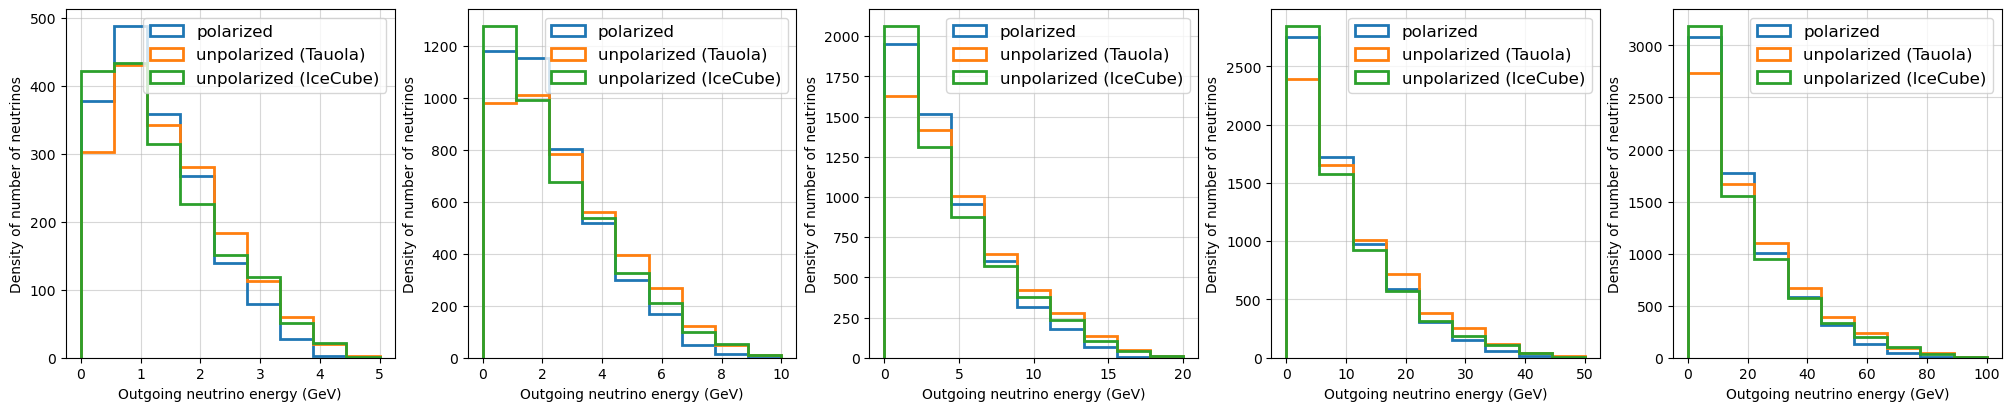

In [94]:
plot_histograms(
    decay_products, decay_products_nopol, decay_products_ic, 
    bins=[np.linspace(0, e, 10) for e in nutau_energies], filter_func=lambda values, index: True, plot_func=lambda x: x[x["pdg"] == 16]["E"],
    xlabel="Outgoing neutrino energy (GeV)",
)

(<Figure size 2000x400 with 5 Axes>,
 array([<Axes: xlabel='Energy (GeV)', ylabel='Density of number of neutrinos'>,
        <Axes: xlabel='Energy (GeV)', ylabel='Density of number of neutrinos'>,
        <Axes: xlabel='Energy (GeV)', ylabel='Density of number of neutrinos'>,
        <Axes: xlabel='Energy (GeV)', ylabel='Density of number of neutrinos'>,
        <Axes: xlabel='Energy (GeV)', ylabel='Density of number of neutrinos'>],
       dtype=object))

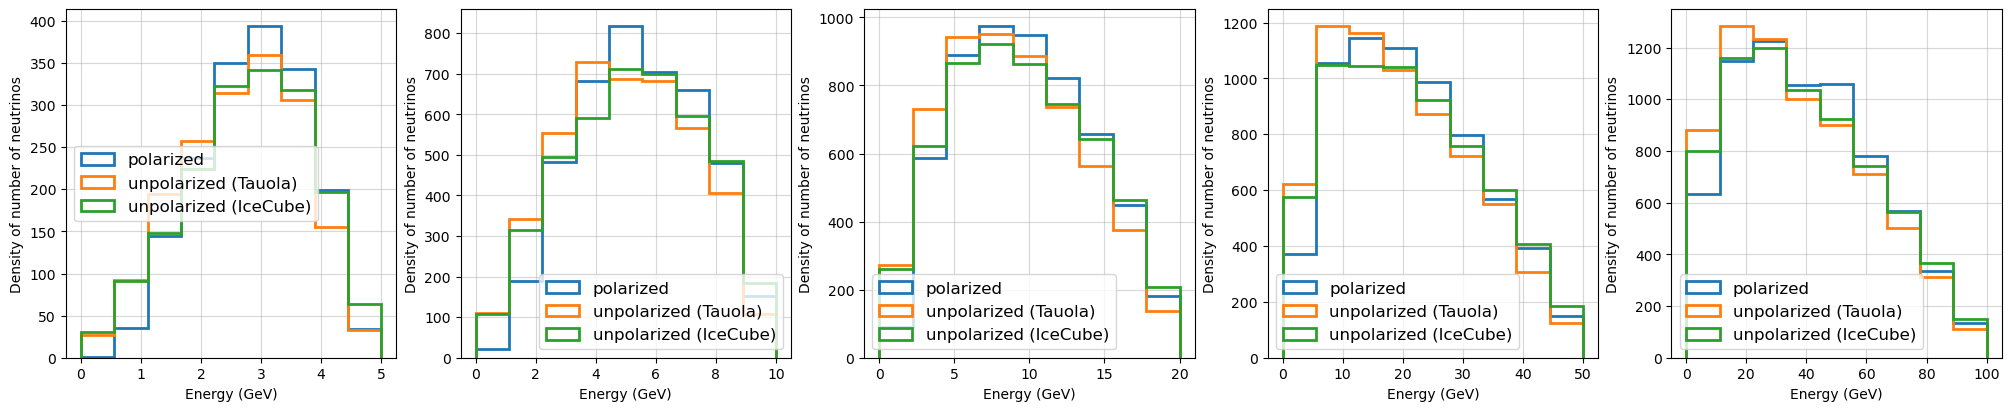

In [95]:
def tau_visible_e(df) -> np.ndarray:
    return df.query("pdg != 16").groupby("event_num")["E"].sum()

plot_histograms(
    decay_products, decay_products_nopol, decay_products_ic, 
    bins=[np.linspace(0, e, 10) for e in nutau_energies], filter_func=lambda values, index: True, plot_func=tau_visible_e, 
    xlabel="Energy (GeV)",
)

In [96]:
@numba.njit
def is_pion_nutau_event(values: np.ndarray, index: np.ndarray) -> bool:
    return (values == -211).any() and (values == 16).any() and (values.size == 2)


def pion_momentum_fraction(decay_products):
    """Calculate the momentum fraction of the pion relative to the total momentum of all decay products"""
    pion_momentum = (
        decay_products
        .query("pdg.abs() == 211")
        .loc[:, "px":"pz"]
        .pow(2)
        .sum(axis=1)
        .pow(0.5)
    )

    decay_products = decay_products.copy()
    decay_products.loc[:, "P"] = decay_products.loc[:, "px":"pz"].pow(2).sum(axis=1).pow(0.5)
    
    tau_momentum = (
        decay_products
        .groupby("event_num")
        ["P"].sum()
    )
    return pion_momentum.values / tau_momentum.values


def nu_momentum_fraction(decay_products):
    """Calculate the momentum fraction of the tau neutrino relative to the total momentum of all decay products"""
    nu_momentum = (
        decay_products
        .query("pdg.abs() == 16")
        .loc[:, "px":"pz"]
        .pow(2)
        .sum(axis=1)
        .pow(0.5)
    )

    decay_products = decay_products.copy()
    decay_products.loc[:, "P"] = decay_products.loc[:, "px":"pz"].pow(2).sum(axis=1).pow(0.5)
    
    tau_momentum = (
        decay_products
        .groupby("event_num")
        ["P"].sum()
    )
    return nu_momentum.values / tau_momentum.values

Text(0.5, 0.98, 'Pion momentum fraction for $\\tau^- \\to \\pi^- \\nu_\\tau$ events')

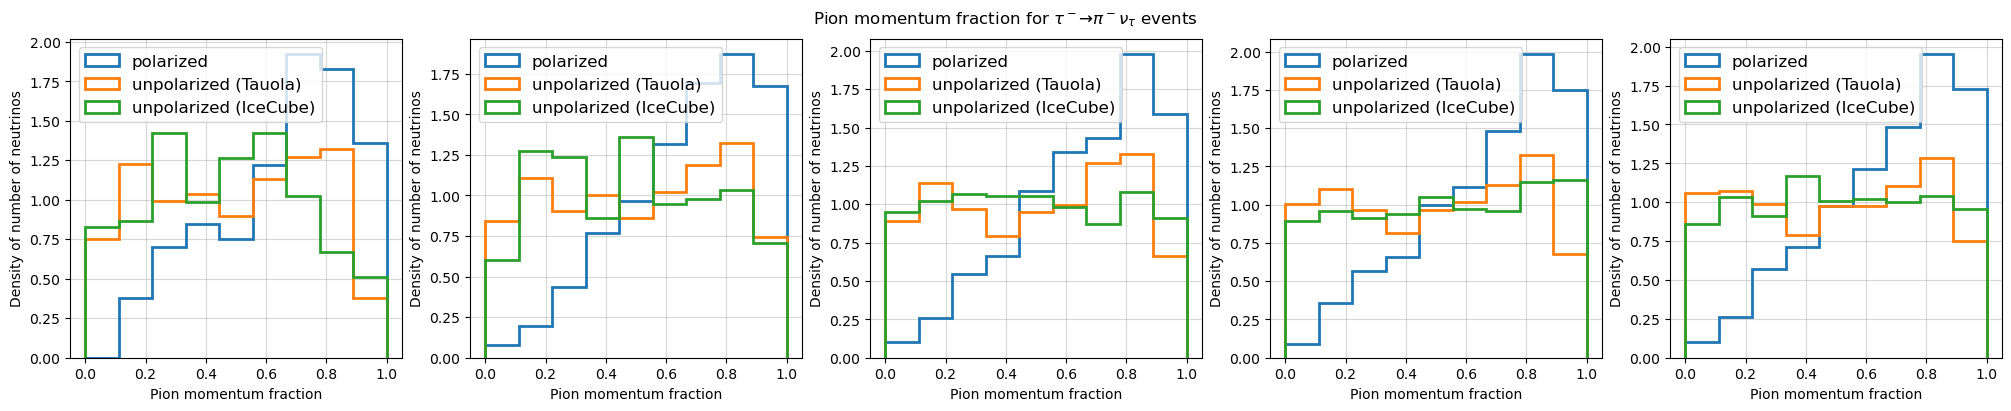

In [97]:
fig, axs = plot_histograms(
    decay_products, decay_products_nopol, decay_products_ic, 
    bins=[np.linspace(0, 1, 10) for e in nutau_energies], filter_func=is_pion_nutau_event, plot_func=pion_momentum_fraction, 
    xlabel="Pion momentum fraction", density=True,
)
fig.suptitle(r"Pion momentum fraction for $\tau^- \to \pi^- \nu_\tau$ events")

Text(0.5, 0.98, 'Neutrino momentum fraction for $\\tau^- \\to \\pi^- \\nu_\\tau$ events')

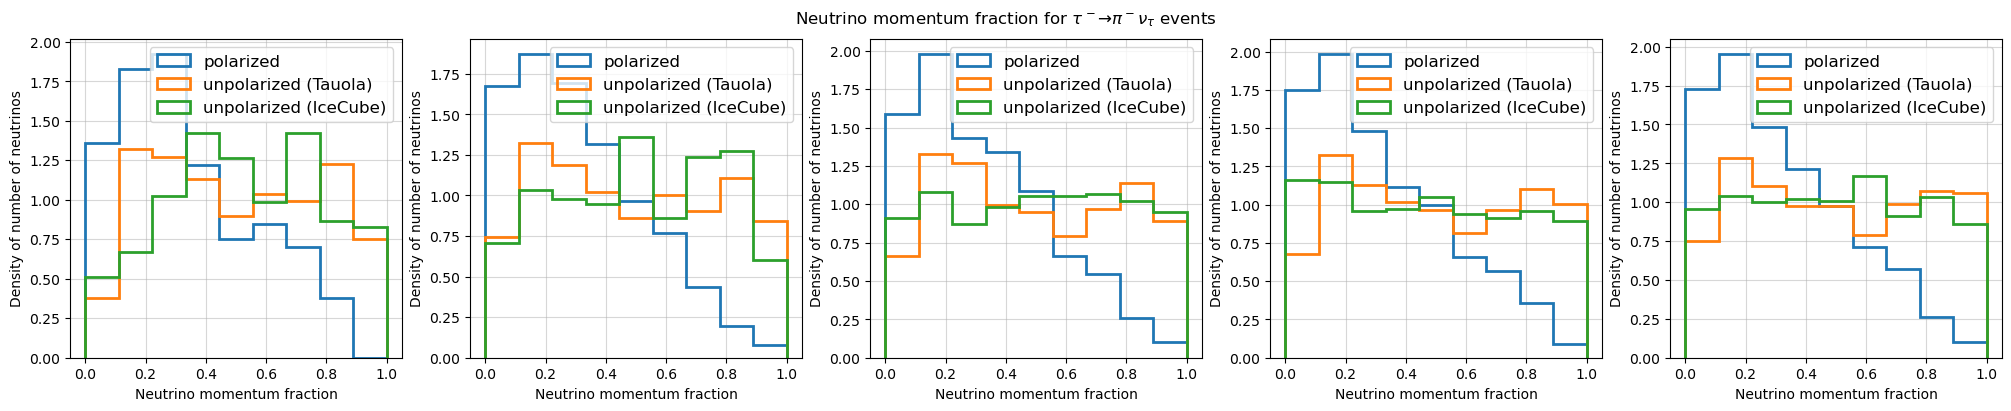

In [98]:
fig, axs = plot_histograms(
    decay_products, decay_products_nopol, decay_products_ic, 
    bins=[np.linspace(0, 1, 10) for e in nutau_energies], filter_func=is_pion_nutau_event, plot_func=nu_momentum_fraction, 
    xlabel="Neutrino momentum fraction", density=True,
)
fig.suptitle(r"Neutrino momentum fraction for $\tau^- \to \pi^- \nu_\tau$ events")

We see a clear difference between the decay using Tauola with real polarization given by GENIE and the unpolarized decay by Geant4.
A similar difference would likely be seen for the IceCube simulations.

In [99]:
@numba.njit
def is_pi0_pim_nutau_event(values, index) -> bool:
    """Check if a given event contains a pi0, a pi- and a tau neutrino"""
    return ((values == -211).sum() == 1) and ((values == 111).sum() == 1) and (values == 16).any() and (values.size == 3)

Text(0.5, 0.98, 'Neutrino momentum fraction for $\\tau^- \\to \\pi^0 \\pi^- \\nu_\\tau$ events')

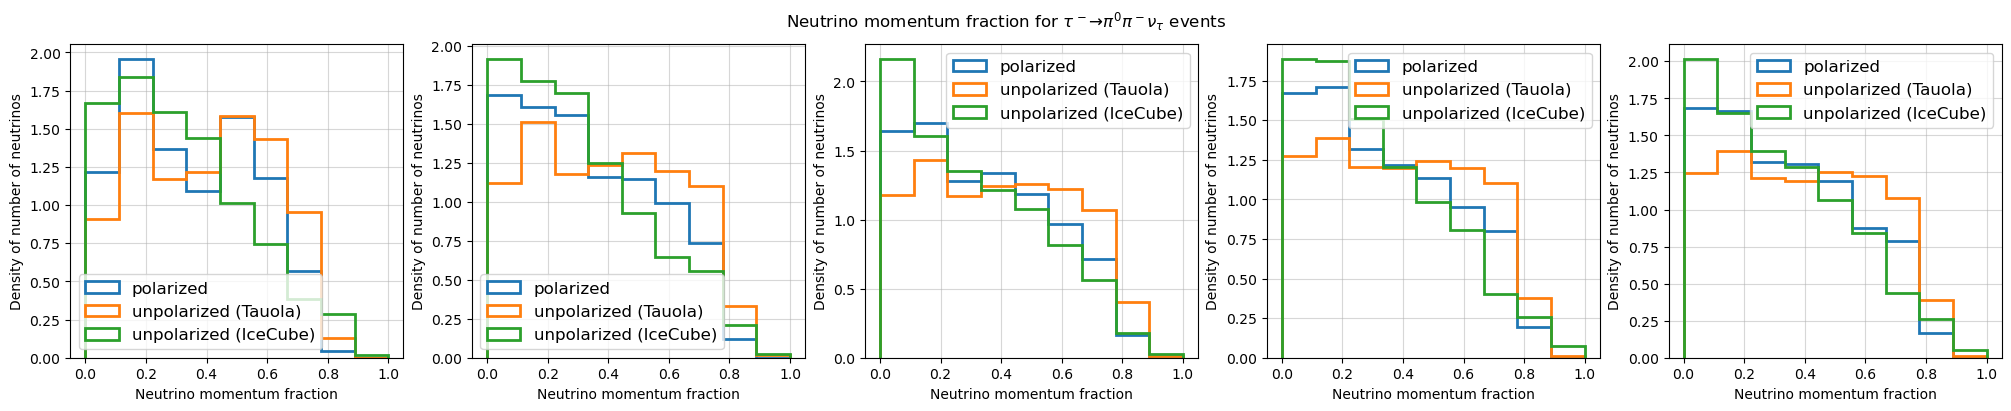

In [100]:
fig, axs = plot_histograms(
    decay_products, decay_products_nopol, decay_products_ic, 
    bins=[np.linspace(0, 1, 10) for e in nutau_energies], filter_func=is_pi0_pim_nutau_event, plot_func=nu_momentum_fraction, 
    xlabel="Neutrino momentum fraction", density=True,
)
fig.suptitle(r"Neutrino momentum fraction for $\tau^- \to \pi^0 \pi^- \nu_\tau$ events")

In [101]:
@numba.njit
def is_2pim_pip_nutau_event(values, index) -> bool:
    return ((values == -211).sum() == 2) and ((values == 211).sum() == 1) and (values == 16).any() and (values.size == 4)

Text(0.5, 0.98, 'Neutrino momentum fraction for $\\tau^- \\to \\pi^- \\pi^- \\pi^+ \\nu_\\tau$ events')

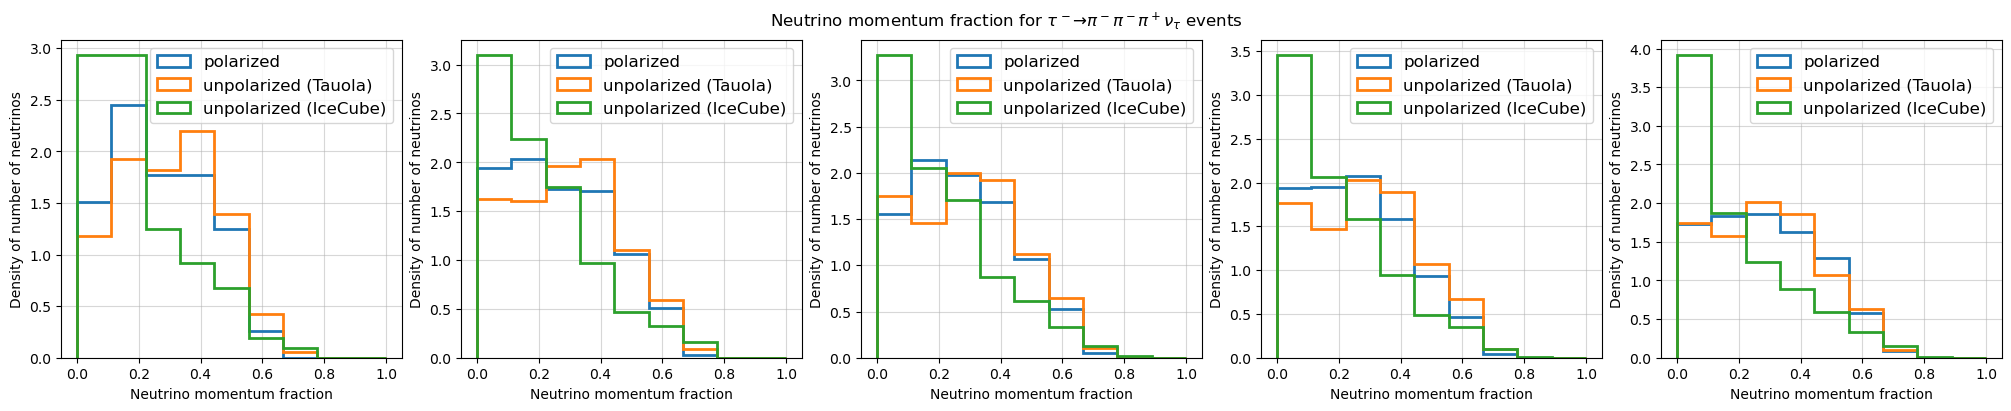

In [102]:
fig, axs = plot_histograms(
    decay_products, decay_products_nopol, decay_products_ic, 
    bins=[np.linspace(0, 1, 10) for e in nutau_energies], filter_func=is_2pim_pip_nutau_event, plot_func=nu_momentum_fraction, 
    xlabel="Neutrino momentum fraction", density=True,
)
fig.suptitle(r"Neutrino momentum fraction for $\tau^- \to \pi^- \pi^- \pi^+ \nu_\tau$ events")

In [103]:
@numba.njit
def is_2pi0_pim_nutau_event(values, index) -> bool:
    return ((values == -211).sum() == 1) and ((values == 111).sum() == 2) and (values == 16).any() and (values.size == 4)

Text(0.5, 0.98, 'Neutrino momentum fraction for $\\tau^- \\to \\pi^0 \\pi^0 \\pi^- \\nu_\\tau$ events')

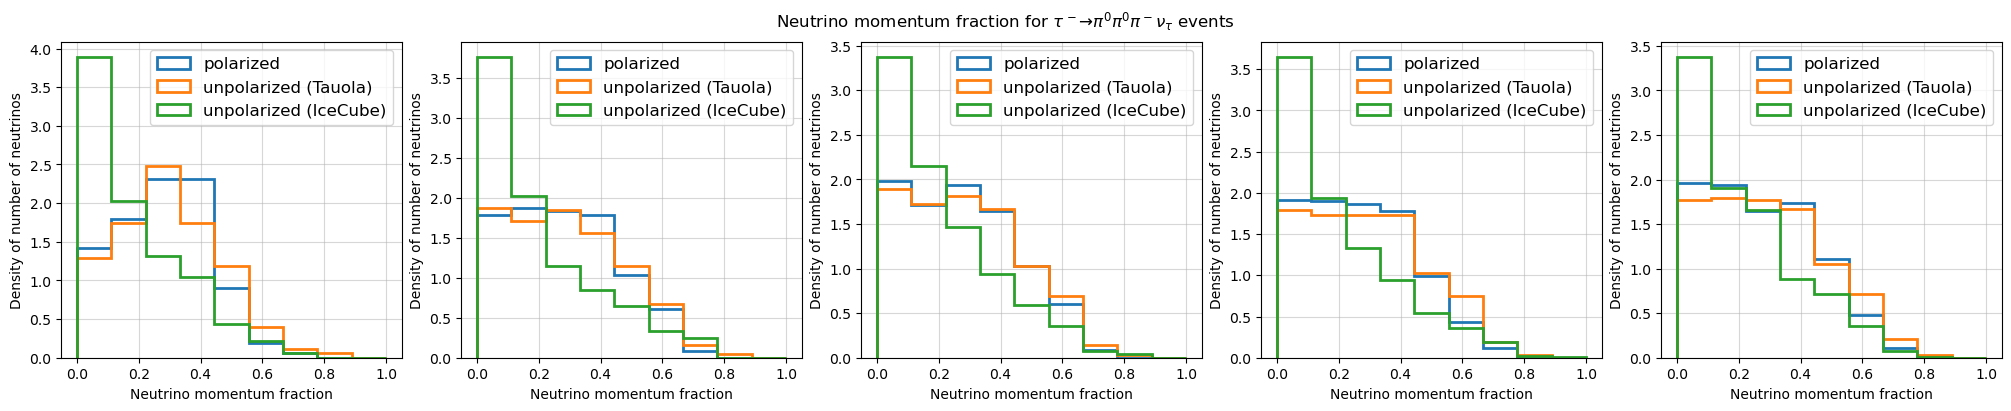

In [104]:
fig, axs = plot_histograms(
    decay_products, decay_products_nopol, decay_products_ic, 
    bins=[np.linspace(0, 1, 10) for e in nutau_energies], filter_func=is_2pi0_pim_nutau_event, plot_func=nu_momentum_fraction, 
    xlabel="Neutrino momentum fraction", density=True,
)
fig.suptitle(r"Neutrino momentum fraction for $\tau^- \to \pi^0 \pi^0 \pi^- \nu_\tau$ events")

In [105]:
@numba.njit
def is_mu_numu_nutau_event(values, index) -> bool:
    return ((values == 13).sum() == 1) and ((values == -14).sum() == 1) and (values == 16).any() and (values.size == 3)

Text(0.5, 0.98, 'Neutrino momentum fraction for $\\tau^- \\to \\bar\\nu_\\mu \\mu^- \\nu_\\tau$ events')

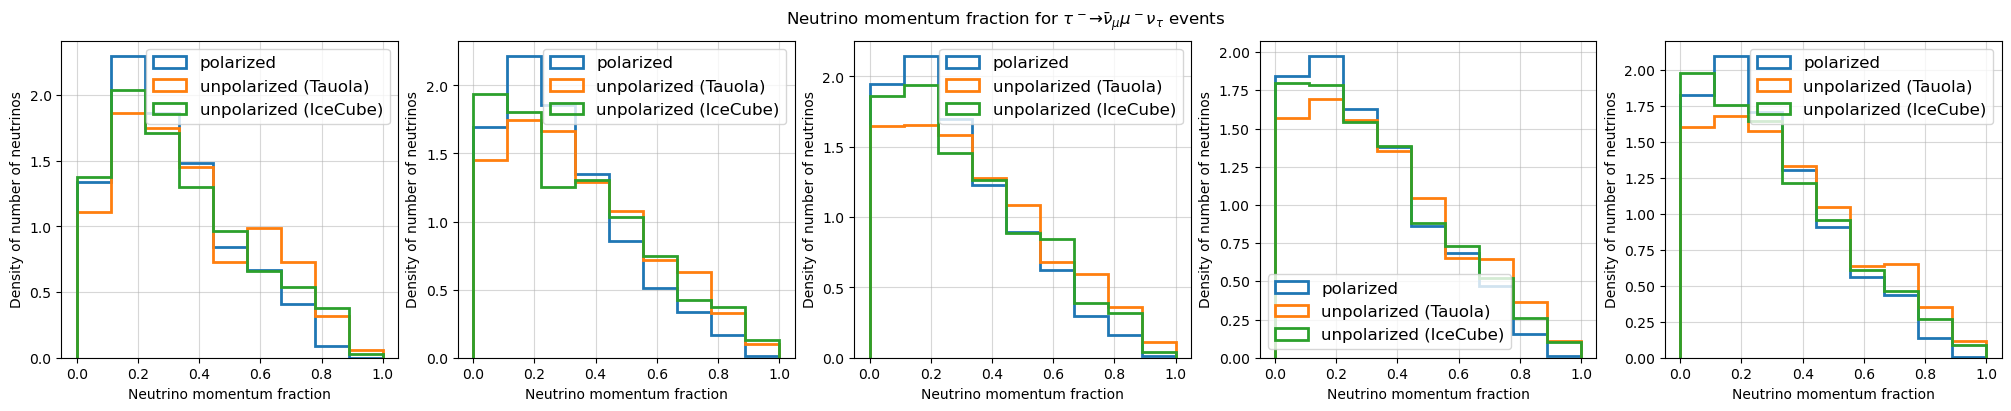

In [106]:
fig, axs = plot_histograms(
    decay_products, decay_products_nopol, decay_products_ic, 
    bins=[np.linspace(0, 1, 10) for e in nutau_energies], filter_func=is_mu_numu_nutau_event, plot_func=nu_momentum_fraction, 
    xlabel="Neutrino momentum fraction", density=True,
)
fig.suptitle(r"Neutrino momentum fraction for $\tau^- \to \bar\nu_\mu \mu^- \nu_\tau$ events")

In [107]:
@numba.njit
def is_e_nue_nutau_event(values, index) -> bool:
    return ((values == 11).sum() == 1) and ((values == -12).sum() == 1) and (values == 16).any() and (values.size == 3)

Text(0.5, 0.98, 'Neutrino momentum fraction for $\\tau^- \\to \\bar\\nu_e e^- \\nu_\\tau$ events')

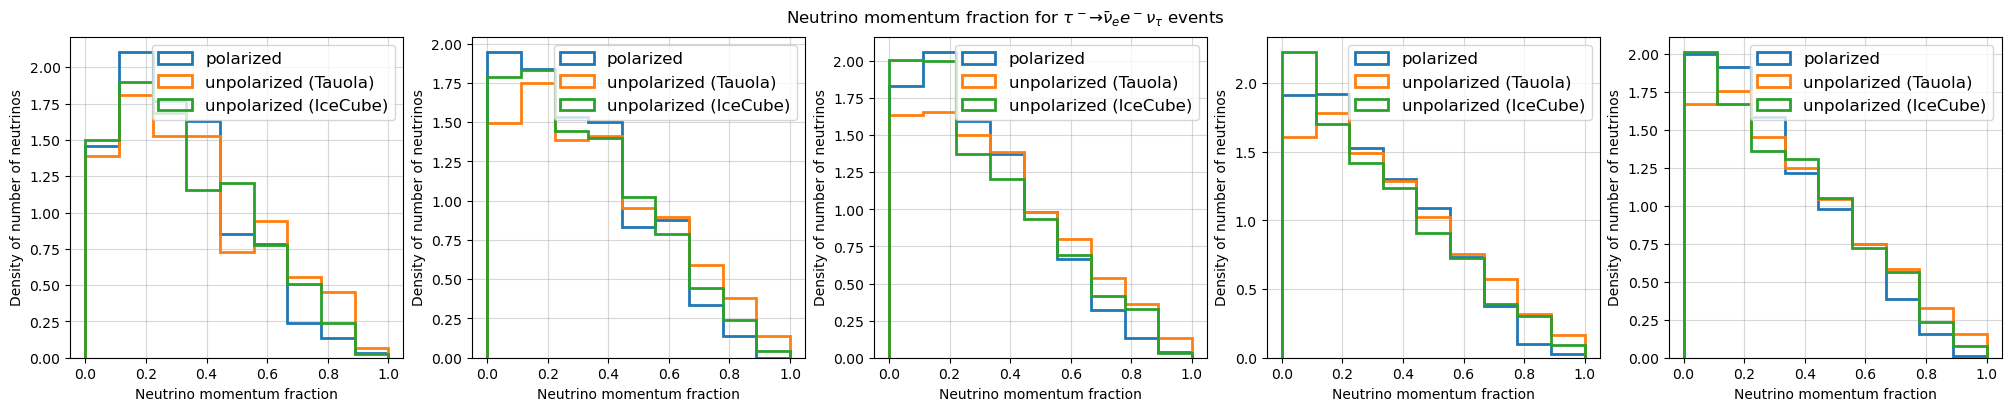

In [108]:
fig, axs = plot_histograms(
    decay_products, decay_products_nopol, decay_products_ic, 
    bins=[np.linspace(0, 1, 10) for e in nutau_energies], filter_func=is_e_nue_nutau_event, plot_func=nu_momentum_fraction, 
    xlabel="Neutrino momentum fraction", density=True,
)
fig.suptitle(r"Neutrino momentum fraction for $\tau^- \to \bar\nu_e e^- \nu_\tau$ events")

In [122]:
# Check that all events from IceCube are covered by the filter functions above, i.e. I have plotted all possible decay modes in Geant4
for e in nutau_energies:
    mask = [
        decay_products_ic[e].groupby("event_num")["pdg"].agg(filter_func, engine="numba") 
        for filter_func in 
        (is_pion_nutau_event, is_pi0_pim_nutau_event, is_2pim_pip_nutau_event, is_2pi0_pim_nutau_event, is_mu_numu_nutau_event, is_e_nue_nutau_event)
    ]
    assert (np.sum(mask, axis=0) == 1).all()

# Old IceCube simulations
These events have incoming neutrinos with various energies. Also, the tau leptons do not have polarization information. Lastly, more Geant4 decay modes are possible, though many of them do not conserve 4-momentum and charge etc, so the results should not be trusted.
 
## Energy of tau neutrino

In [169]:
decays_icecube = particle_info.groupby("event_num").nth[3:]
nutau_icecube_e = decays_icecube.query("pdg == 16")["E"]
anti_nutau_icecube_e = decays_icecube.query("pdg == -16")["E"]

nutau_e = decay_products.query("pdg == 16")["E"]
anti_nutau_e = decay_products.query("pdg == -16")["E"]

nutau_nopol_e = decay_products_nopol.query("pdg == 16")["E"]
anti_nutau_nopol_e = decay_products_nopol.query("pdg == -16")["E"]

In [171]:
assert len(nutau_e) == len(nutau_icecube_e)
assert len(anti_nutau_e) == len(anti_nutau_icecube_e)
assert len(nutau_nopol_e) == len(nutau_icecube_e)
assert len(anti_nutau_nopol_e) == len(anti_nutau_icecube_e)

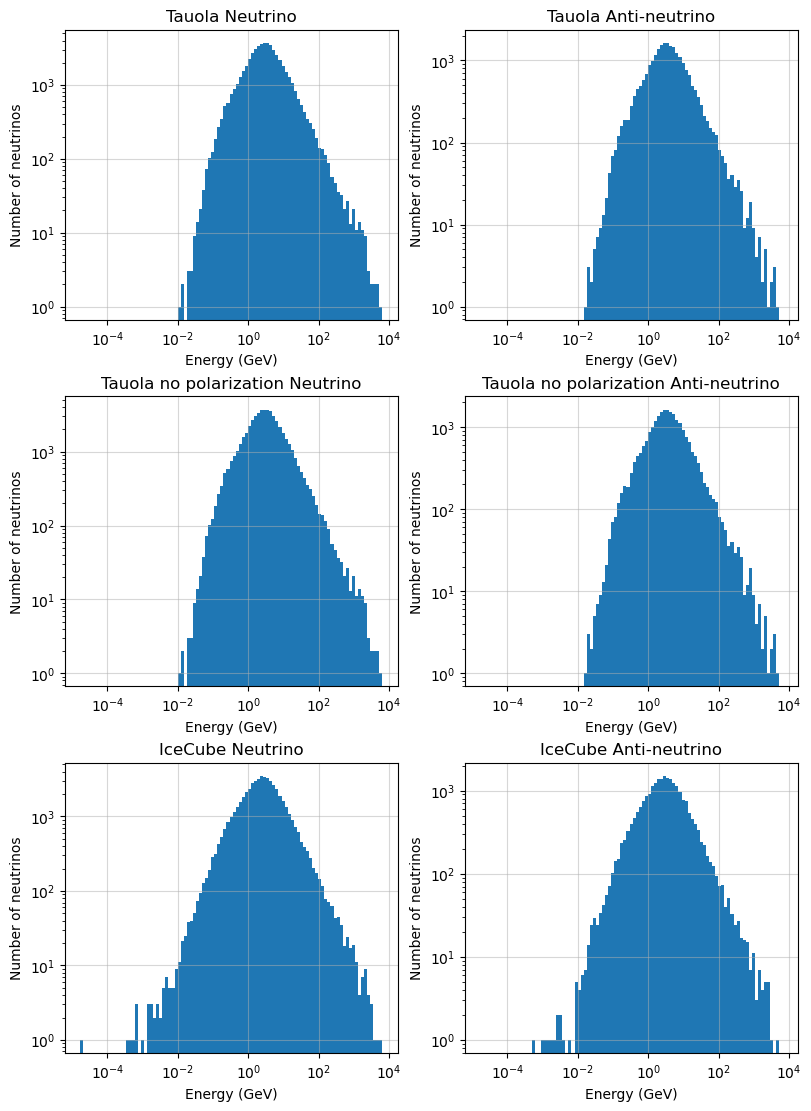

In [172]:
fig, axs = plt.subplots(figsize=(8, 11), nrows=3, ncols=2, layout="constrained")

min_energy = np.min(np.r_[nutau_e, anti_nutau_e, nutau_icecube_e, anti_nutau_icecube_e])
max_energy = np.max(np.r_[nutau_e, anti_nutau_e, nutau_icecube_e, anti_nutau_icecube_e])

for ax_row, label, lists, in zip(axs, ("Tauola", "Tauola no polarization", "IceCube"), ((nutau_e, anti_nutau_e), (nutau_nopol_e, anti_nutau_nopol_e), (nutau_icecube_e, anti_nutau_icecube_e))):
    for ax, energies, particle_type in zip(ax_row, lists, ("Neutrino", "Anti-neutrino")):
        ax.hist(energies, bins=np.geomspace(min_energy, max_energy, 100), label=f"{label} {particle_type}")
        ax.set_title(f"{label} {particle_type}")
        
for ax in axs.flat:
    ax.set(xscale="log", yscale="log", xlabel="Energy (GeV)", ylabel="Number of neutrinos")
    ax.grid(True, alpha=0.5)
    # ax.legend(fontsize="large")

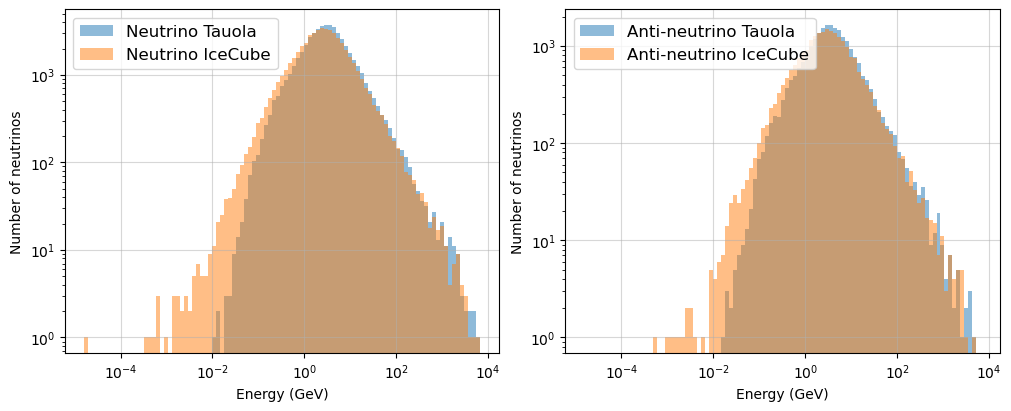

In [173]:
fig, axs = plt.subplots(figsize=(10, 4), nrows=1, ncols=2, layout="constrained")

min_energy = np.min(np.r_[nutau_e, anti_nutau_e, nutau_icecube_e, anti_nutau_icecube_e])
max_energy = np.max(np.r_[nutau_e, anti_nutau_e, nutau_icecube_e, anti_nutau_icecube_e])

for ax, label, lists, in zip(axs, ("Neutrino", "Anti-neutrino"), ((nutau_e, nutau_icecube_e), (anti_nutau_e, anti_nutau_icecube_e))):
    for energies, particle_type in zip(lists, ("Tauola", "IceCube")):
        ax.hist(energies, bins=np.geomspace(min_energy, max_energy, 100), label=f"{label} {particle_type}", alpha=0.5)
        # ax.set_title(f"{label} {particle_type}")
        
for ax in axs.flat:
    ax.set(xscale="log", yscale="log", xlabel="Energy (GeV)", ylabel="Number of neutrinos")
    ax.grid(True, alpha=0.5)
    ax.legend(fontsize="large")

It seems like neutrinos tend to have lower energies for IceCube compared to Tauola. This would mean that the IceCube simulations overestimate the energy deposited in the detector.

## Low energy incoming tau neutrinos

In [29]:
# Select only events where the incoming neutrino has energy < 5 GeV
low_energy_events = particle_info.groupby("event_num").filter(lambda df: df.iloc[1, 2] < 5.)

In [30]:
decays_icecube_low_energy = decays_icecube[decays_icecube["event_num"].isin(low_energy_events["event_num"])]
nutau_icecube_e_le = decays_icecube_low_energy.query("pdg == 16")["E"]
anti_nutau_icecube_e_le = decays_icecube_low_energy.query("pdg == -16")["E"]

decays_low_energy = decay_products[decay_products["event_num"].isin(low_energy_events["event_num"])]
nutau_e_le = decays_low_energy.query("pdg == 16")["E"]
anti_nutau_e_le = decays_low_energy.query("pdg == -16")["E"]

/tmp/ipykernel_5818/3877334160.py:23: RuntimeWarning: divide by zero encountered in divide
  ax.stairs(hist_list[0] / hist_list[1], bins, color="k")
/tmp/ipykernel_5818/3877334160.py:23: RuntimeWarning: invalid value encountered in divide
  ax.stairs(hist_list[0] / hist_list[1], bins, color="k")


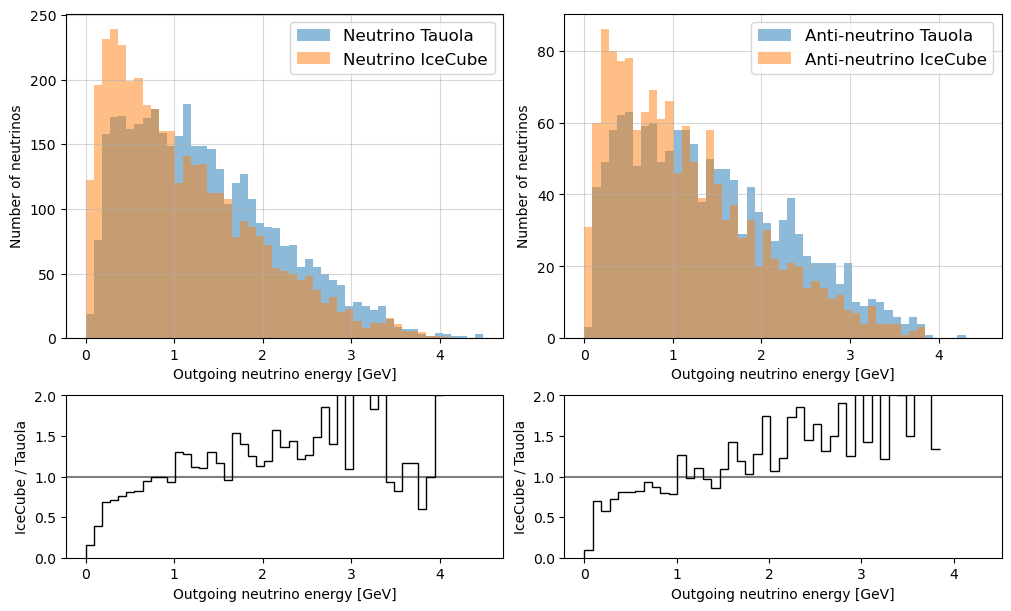

In [55]:
fig, axs = plt.subplots(figsize=(10, 6), nrows=2, ncols=2, layout="constrained", gridspec_kw=dict(height_ratios=(2, 1)))

min_energy = np.min(np.r_[nutau_e_le, anti_nutau_e_le, nutau_icecube_e_le, anti_nutau_icecube_e_le])
max_energy = np.max(np.r_[nutau_e_le, anti_nutau_e_le, nutau_icecube_e_le, anti_nutau_icecube_e_le])
bins = np.linspace(min_energy, max_energy, 50)

histograms = []
for ax, label, lists, in zip(axs[0, :], ("Neutrino", "Anti-neutrino"), ((nutau_e_le, nutau_icecube_e_le), (anti_nutau_e_le, anti_nutau_icecube_e_le))):
    ax_hists = []
    for energies, particle_type in zip(lists, ("Tauola", "IceCube")):
        e_hist, *_ = ax.hist(energies, bins=bins, label=f"{label} {particle_type}", alpha=0.5)
        ax_hists.append(e_hist)
        # ax.set_title(f"{label} {particle_type}")
    histograms.append(ax_hists)

for ax in axs[0, :]:
    ax.set(xlabel="Outgoing neutrino energy [GeV]", ylabel="Number of neutrinos")
    ax.grid(True, alpha=0.5)
    ax.legend(fontsize="large")

# Plot ratio of the histograms in the lower row
for ax, hist_list in zip(axs[1, :], histograms):
    ax.stairs(hist_list[0] / hist_list[1], bins, color="k")
    ax.axhline(1, c="k", alpha=0.5)
    ax.set(ylim=(0, 2), xlabel="Outgoing neutrino energy [GeV]", ylabel="IceCube / Tauola")


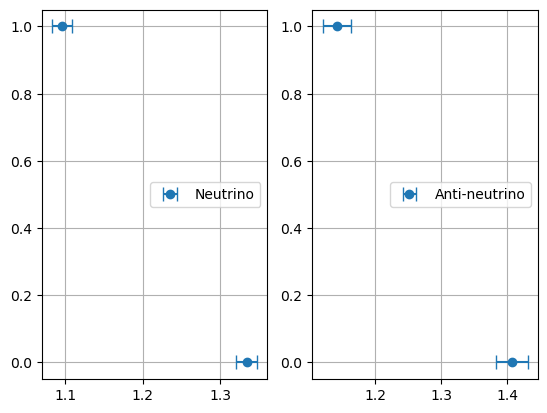

In [53]:
# Plot dots of mean energy with standard deviations. Each row should be a different dataset
# print(f"{np.mean(nutau_e)} +- {np.std(nutau_e)/np.sqrt(len(nutau_e)-1)}, {np.mean(nutau_icecube_e)} +- {np.std(nutau_icecube_e)/np.sqrt(len(nutau_e)-1)}")
fig, (ax, ax_anti) = plt.subplots(ncols=2)
ax.errorbar(
    y=np.arange(2),
    x=[np.mean(nutau_e_le), np.mean(nutau_icecube_e_le)],
    xerr=[np.std(nutau_e_le)/np.sqrt(len(nutau_e_le)-1), np.std(nutau_icecube_e_le)/np.sqrt(len(nutau_icecube_e_le)-1)],
    fmt="o",
    # add vertical lines at the end of the error bars
    capsize=5,
    label="Neutrino"
)
ax.grid()
ax.legend(loc="center right")

ax_anti.errorbar(
    y=np.arange(2),
    x=[np.mean(anti_nutau_e_le), np.mean(anti_nutau_icecube_e_le)],
    xerr=[np.std(anti_nutau_e_le)/np.sqrt(len(anti_nutau_e_le)-1), np.std(anti_nutau_icecube_e_le)/np.sqrt(len(anti_nutau_icecube_e_le)-1)],
    fmt="o",
    # add vertical lines at the end of the error bars
    capsize=5,
    label="Anti-neutrino"
)
ax_anti.grid()
ax_anti.legend(loc="center right")

For low energy primary tau neutrinos, the difference in mean energy is statistically significant between the two simulations. This couls mean that the spin polarization has a meaningful effect on the secondary neutrino energy.

In [57]:
particle_info.groupby("event_num").nth(1)

,event_num,pdg,E,px,py,pz
1,0,-16,3.730323,0.185260,3.295873,1.737299
6,1,16,3.725654,-1.656092,-2.943322,1.573121
13,2,16,3.528632,-2.419746,-2.330455,-1.079378
18,3,16,3.882620,-0.162095,-0.282077,-3.868966
25,4,16,3.909540,0.001797,-0.855136,-3.814871
...,...,...,...,...,...,...
447097,76638,-16,1420.859081,-563.321344,-862.807899,-978.300630
447103,76639,16,5830.060163,-5542.246831,-1435.699600,-1100.848866
447109,76640,-16,1898.861298,1372.595075,-1307.442511,-110.684538
447115,76641,16,2171.189851,-1055.061515,1112.683486,1537.155174


In [150]:
# Sort the events in particle_info based on the energy of the incoming neutrino
current_bin = 0
bin_step = 10
max_bin = 1000
bins = np.arange(current_bin, max_bin+bin_step+1e-6, bin_step)
bin_events = [[]]

for nu in particle_info.groupby("event_num").nth(1).sort_values("E").itertuples():
    if nu.E > current_bin + bin_step:
        current_bin += bin_step
        if current_bin > max_bin:
            break
        bin_events.append([])
    
    bin_events[-1].append(nu.event_num)

In [151]:
# For each energy bin, calculate the mean energy of the secondary neutrino

def get_energies(data, bin_events) -> tuple[list[float], list[float]]:
    mean_energies = []
    std_energies = []
    
    for events in bin_events:
        if len(events) <= 1:
            mean_energies.append(np.nan)
            std_energies.append(np.nan)
            continue

        decays = data[data["event_num"].isin(events)]
        mean_energies.append(np.mean(decays.query("abs(pdg) == 16")["E"]))
        std_energies.append(np.std(decays.query("abs(pdg) == 16")["E"])/np.sqrt(len(events)-1))
    return mean_energies, std_energies

# Tauola
mean_energies, std_energies = get_energies(decay_products, bin_events)
# IceCube
mean_energies_ic, std_energies_ic = get_energies(particle_info.groupby("event_num").nth[3:], bin_events)

In [152]:
len(mean_energies), len(bins)

(101, 102)

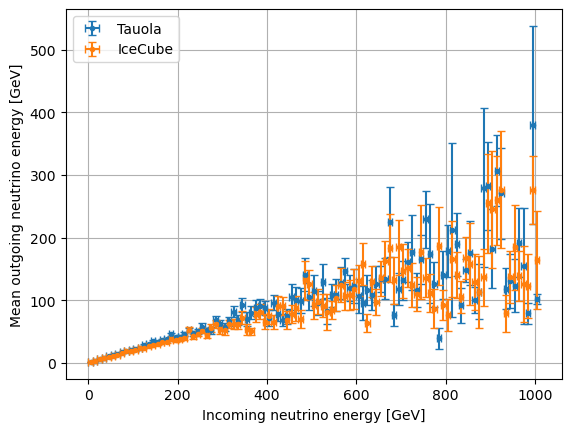

In [162]:
# Plot mean energies with standard deviations
fig, ax = plt.subplots()
plot_settings = dict(
    x=(bins[1:] + bins[:-1])/2,
    xerr=bin_step/2,
    fmt="o",
    # add vertical lines at the end of the error bars
    capsize=3,
    markersize=3,
)

ax.errorbar(
    y=mean_energies,
    yerr=std_energies,
    label="Tauola",
    **plot_settings,
)
ax.errorbar(
    y=mean_energies_ic,
    yerr=std_energies_ic,
    label="IceCube",
    **plot_settings,
)
ax.set(xlabel="Incoming neutrino energy [GeV]", ylabel="Mean outgoing neutrino energy [GeV]")
ax.legend()
ax.grid()

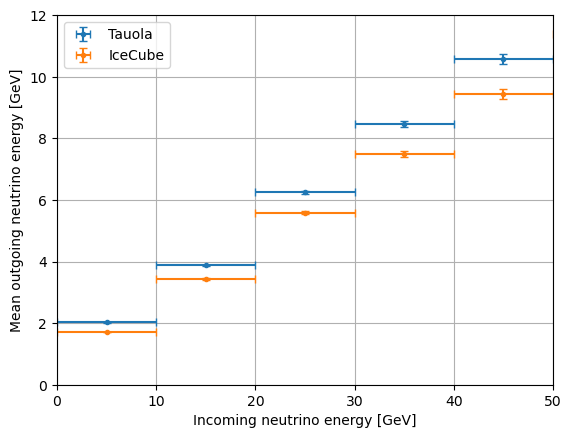

In [165]:
ax.set(xlim=(0, 50), ylim=(0, 12))
fig

Clearly for lower energies, the two decay simulations differ significantly from each other.

## Branching ratios for Tauola events

In [20]:
c = Counter(tuple(sorted(a.tolist())) for i, a in decay_products.groupby("event_num")["pdg"])

In [21]:
n_taus = (particle_info["pdg"] == 15).sum()
n_anti_taus = (particle_info["pdg"] == -15).sum()
n_taus, n_anti_taus

(53172, 23471)

In [22]:
br = {}
for pdgs, n in c.items():
    if 16 in pdgs:
        br[pdgs] = n / n_taus
    elif -16 in pdgs:
        br[pdgs] = n / n_anti_taus
    else:
        raise ValueError("No tau in the event")
br

{(-16, 211): 0.11000809509607601,
 (-211, 16, 111): 0.24992477243662078,
 (-211, 16): 0.1117505453998345,
 (-12, 11, 16): 0.1562288422477996,
 (-211, -211, 16, 211): 0.08920108327691266,
 (-16, 111, 211): 0.2545694687060628,
 (-211, -16, 211, 211): 0.08418899919049039,
 (-14, 13, 16): 0.17065372752576544,
 (-211, 16, 111, 111): 0.09294365455502897,
 (-16, -11, 12): 0.15593711388522005,
 (-211, -211, 16, 111, 211): 0.04500488979161965,
 (-16, -11, 12, 22): 0.028801499723062503,
 (-211, 16, 310): 0.0042315504400812455,
 (-16, -13, 14): 0.17148821950492096,
 (-211, 16, 130): 0.004269164221770857,
 (-211, -16, 111, 211, 211): 0.045630778407396363,
 (-211, 16, 130, 130): 0.00028210336267208303,
 (-16, 111, 111, 211): 0.09100592220186614,
 (-321, 16, 111): 0.004476040021063717,
 (-12, 11, 16, 22): 0.026724591890468666,
 (-211, 16, 111, 310): 0.003046716316858497,
 (-321, -211, 16, 211): 0.005134281200631911,
 (-321, -211, 16, 321): 0.0014857443767396373,
 (-211, -211, 16, 111, 111, 111, 211)

In [23]:
pdg2name = {15: "tau-", 16: "nu_tau", 211: "pi+", -15: "tau+", -16: "nu_tau_bar", -211: "pi-", 111: "pi0", 13: "mu-", -13: "mu+", 14: "nu_mu", -14: "nu_mu_bar", 11: "e-", -11: "e+", 12: "nu_e", -12: "nu_e_bar", 22: 
            "gamma", 310: "K^0_S", 130: "K^0_L", 321: "K+", -321: "K-"}

for pdgs, n in br.items():
    for pdg in pdgs:
        print(pdg2name[pdg], end=" ")
    print(":", n*100)

nu_tau_bar pi+ : 11.0008095096076
pi- nu_tau pi0 : 24.99247724366208
pi- nu_tau : 11.175054539983451
nu_e_bar e- nu_tau : 15.622884224779959
pi- pi- nu_tau pi+ : 8.920108327691265
nu_tau_bar pi0 pi+ : 25.456946870606277
pi- nu_tau_bar pi+ pi+ : 8.41889991904904
nu_mu_bar mu- nu_tau : 17.065372752576543
pi- nu_tau pi0 pi0 : 9.294365455502897
nu_tau_bar e+ nu_e : 15.593711388522005
pi- pi- nu_tau pi0 pi+ : 4.500488979161965
nu_tau_bar e+ nu_e gamma : 2.8801499723062505
pi- nu_tau K^0_S : 0.42315504400812454
nu_tau_bar mu+ nu_mu : 17.148821950492096
pi- nu_tau K^0_L : 0.42691642217708564
pi- nu_tau_bar pi0 pi+ pi+ : 4.563077840739636
pi- nu_tau K^0_L K^0_L : 0.028210336267208303
nu_tau_bar pi0 pi0 pi+ : 9.100592220186615
K- nu_tau pi0 : 0.44760400210637175
nu_e_bar e- nu_tau gamma : 2.6724591890468665
pi- nu_tau pi0 K^0_S : 0.3046716316858497
K- pi- nu_tau pi+ : 0.5134281200631912
K- pi- nu_tau K+ : 0.14857443767396372
pi- pi- nu_tau pi0 pi0 pi0 pi+ : 0.047017227112013844
nu_tau_bar pi0 p

KeyError: 221

In [24]:
# nutau_e = []
# anti_nutau_e = []
def identify_strange_events():
    with pyhepmc.open("tauola_output.dat", "r") as f:
        # Iterate over all events
        for i, evt in enumerate(f):
            # Find the tau and identify its daughter tau neutrino
            for vertex in evt.vertices:
                # Check if there is a tau neutrino as incoming particle
                # If it is, skip the vertex
                if any(np.abs(p.pid) == 16 for p in vertex.particles_in):
                    continue
                
                # Find the daughter tau neutrino
                for daughter in vertex.particles_out:
                    # If it is not a final state particle, skip it
                    if daughter.status != 1:
                        continue
                    
                    if np.abs(daughter.pid) not in {11, 12, 13, 14, 16, 111, 211, 22}:
                        return evt
                    
identify_strange_events()

<GenEvent momentum_unit=1, length_unit=0, event_number=32, particles=7, vertices=3, run_info=GenRunInfo(tools=[], weight_names=[], attributes={})>